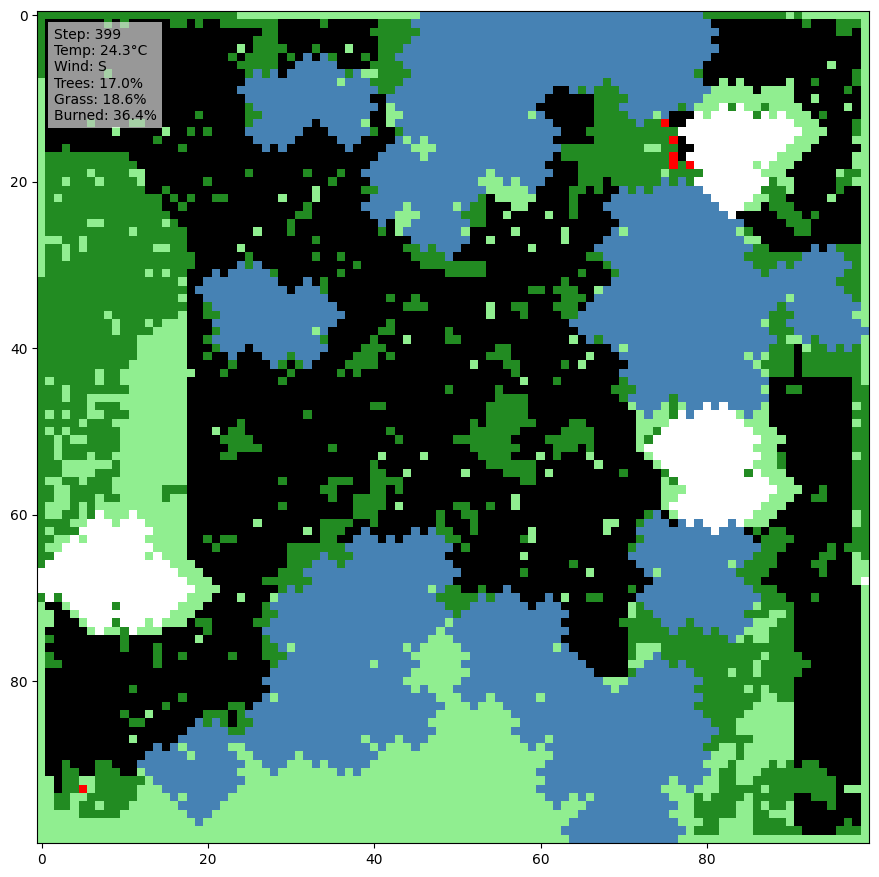

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib.colors import BoundaryNorm

class WFSim:
    def __init__(self, f=0.0001, p=0.01, bedrock=0.01, water=0.02, h=100, w=100, forest_fraction=0.05, ash_lifetime=5,
                 avg_temp=20, temp_amplitude=5, temp_noise=2, wind='random'):
        """
        Initialize the simulation with probabilities for fire, tree growth,
        bedrock, water, temperature, and wind, along with grid dimensions.
        """
        self.f = f  # Base probability of lightning strike
        self.p = p  # Probability of new tree growth
        self.bedrock = bedrock  # Fraction of bedrock
        self.water = water  # Fraction of water
        self.ash_lifetime = ash_lifetime  # Lifetime of ash
        self.h = h  # Grid height
        self.w = w  # Grid width
        self.avg_temp = avg_temp  # Average daily temperature
        self.temp_amplitude = temp_amplitude  # Amplitude of daily temperature variation
        self.temp_noise = temp_noise  # Noise level for temperature

        # Initialize wind
        valid_wind_directions = ['S', 'N', 'W', 'E', 'SW', 'SE', 'NW', 'NE']
        self.wind = np.random.choice(valid_wind_directions) if wind == 'random' else wind
        self.offsets = {
            'N': [(-1, 0)],
            'S': [(1, 0)],
            'E': [(0, 1)],
            'W': [(0, -1)],
            'NE': [(-1, 1)],
            'NW': [(-1, -1)],
            'SE': [(1, 1)],
            'SW': [(1, -1)]
        }

        # Initialize the grid with default EMPTY cells
        self.landscape = np.zeros((self.h, self.w))

        # Timer array for ash cells
        self.ash_timer = np.zeros((self.h, self.w), dtype=int)

        # Temperature array for the current day
        self.temp = self.generate_temperature()

        # Cloud positions
        self.clouds = np.zeros((self.h, self.w), dtype=bool)  # True indicates a cloud

        # Generate initial cloud clusters
        self.generate_initial_cloud_clusters()

        # Generate stone clusters
        self.create_stone_clusters()

        # Generate water clusters
        self.create_water_clusters()

        # Assign trees in clusters to remaining EMPTY cells
        self.create_forest_clusters(forest_fraction)

    def generate_temperature(self):
        """
        Generate a 24-hour temperature profile using a sine wave with noise.
        """
        hours = np.arange(24)
        temperatures = self.avg_temp + self.temp_amplitude * np.sin(2 * np.pi * hours / 24 - np.pi / 2)
        temperatures += np.random.normal(0, self.temp_noise, 24)  # Add noise
        return temperatures

    def generate_initial_cloud_clusters(self):
        """
        Generate initial clusters of clouds randomly on the grid.
        """
        num_clusters = 3  # Number of cloud clusters
        cluster_size_range = (10, 20)  # Min and max size of each cluster

        for _ in range(num_clusters):
            # Randomly pick a starting point for the cluster
            start_i, start_j = np.random.randint(0, self.h), np.random.randint(0, self.w)
            cluster_size = np.random.randint(*cluster_size_range)

            # Generate the cluster
            self.generate_cluster(start_i, start_j, cluster_size, is_cloud=True)

    def generate_cluster(self, i, j, remaining, is_cloud=False, forest=False):
        """
        Recursively generate a cluster starting from a specific cell.
        """
        if remaining <= 0 or not (0 <= i < self.h and 0 <= j < self.w):
            return
        if is_cloud and self.clouds[i, j]:  # Avoid overwriting existing clouds
            return
        if forest and self.landscape[i, j] != 0:  # Avoid overwriting non-empty cells
            return
        if not is_cloud and not forest and self.landscape[i, j] != 0:  # Avoid overwriting non-empty cells
            return

        if is_cloud:
            self.clouds[i, j] = True  # Mark as cloud
        elif forest:
            self.landscape[i, j] = 1  # TREE
        else:
            self.landscape[i, j] = -3  # Water or stone

        offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Only cardinal directions for better clustering
        np.random.shuffle(offsets)  # Randomize direction to avoid predictable patterns
        for di, dj in offsets:
            self.generate_cluster(i + di, j + dj, remaining - 1, is_cloud, forest)

    def create_stone_clusters(self):
        """
        Create clusters of stone cells to form larger, connected stone areas.
        """
        total_stone_cells = int(self.h * self.w * self.bedrock)  # Total stone cells
        while total_stone_cells > 0:
            i, j = np.random.randint(0, self.h), np.random.randint(0, self.w)
            if self.landscape[i, j] == 0:  # Only start stone cluster in empty cells
                cluster_size = min(np.random.randint(10, 20), total_stone_cells)  # Cluster size 10-20 cells
                self.generate_cluster(i, j, cluster_size, is_cloud=False)
                total_stone_cells -= cluster_size

    def create_water_clusters(self):
        """
        Create clusters of water cells to form larger, connected water bodies.
        """
        total_water_cells = int(self.h * self.w * self.water)  # Total water cells
        while total_water_cells > 0:
            i, j = np.random.randint(0, self.h), np.random.randint(0, self.w)
            if self.landscape[i, j] == 0:  # Only start water cluster in empty cells
                cluster_size = min(np.random.randint(40, 50), total_water_cells)  # Cluster size 40-50 cells
                self.generate_cluster(i, j, cluster_size, is_cloud=False)
                total_water_cells -= cluster_size

    def create_forest_clusters(self, forest_fraction):
        """
        Create clusters of forest cells to form larger, connected forested areas.
        """
        total_forest_cells = int(self.h * self.w * forest_fraction)  # Total forest cells
        while total_forest_cells > 0:
            i, j = np.random.randint(1, self.h - 1), np.random.randint(1, self.w - 1)
            if self.landscape[i, j] == 0:  # Only start forest cluster in empty cells
                cluster_size = min(np.random.randint(20, 50), total_forest_cells)  # Cluster size 20-50 cells
                self.generate_cluster(i, j, cluster_size, forest=True)
                total_forest_cells -= cluster_size

    def move_clouds(self):
        """
        Move clouds across the grid based on the current wind direction.
        Wrap clouds around the edges of the grid to simulate continuous movement.
        """
        new_clouds = np.zeros((self.h, self.w), dtype=bool)
        di, dj = self.offsets[self.wind][0]  # Get wind direction offset
        for i in range(self.h):
            for j in range(self.w):
                if self.clouds[i, j]:
                    ni, nj = (i + di) % self.h, (j + dj) % self.w  # Wrap around edges
                    new_clouds[ni, nj] = True
        self.clouds = new_clouds

    def rain_on_ash(self):
        """
        Clouds convert ash cells (-1) into grass (0).
        """
        for i in range(self.h):
            for j in range(self.w):
                if self.clouds[i, j] and self.landscape[i, j] == -1:  # If cloud is over ash
                    self.landscape[i, j] = 0  # Convert ash to grass

    def fire_neighbors_check(self, idx, jdx):
        """
        Check if any neighbors in the wind direction or nearby are on fire.
        Introduce randomness and weighting for organic fire spread.
        """
        offsets = self.offsets[self.wind]  # Wind-influenced neighbors
        extended_offsets = [(-1, -1), (-1, 0), (-1, 1),
                            (0, -1),         (0, 1),
                            (1, -1), (1, 0), (1, 1)]  # All neighboring cells

        # Add randomness to simulate organic fire spread
        for di, dj in extended_offsets:
            ni, nj = idx + di, jdx + dj
            if 0 <= ni < self.h and 0 <= nj < self.w:
                if self.landscape[ni, nj] == 2:  # Check if neighbor is on fire
                    if (di, dj) in offsets:  # Wind direction gets a higher chance
                        if np.random.random() < 0.8:  # 80% chance due to wind
                            return True
                    else:
                        if np.random.random() < 0.3:  # 30% chance for other neighbors
                            return True
        return False

    def update_wind(self):
        """
        Update the wind direction randomly over time to simulate natural variation.
        """
        if np.random.random() < 0.1:  # 10% chance to change wind direction per step
            valid_wind_directions = ['S', 'N', 'W', 'E', 'SW', 'SE', 'NW', 'NE']
            self.wind = np.random.choice(valid_wind_directions)

    def step(self, step):
        """
        Perform a single simulation step, updating the grid based on the rules.
        """
        # Update wind occasionally
        self.update_wind()

        # Move clouds and rain on ash
        self.move_clouds()
        self.rain_on_ash()

        # Update temperature daily
        if step % 24 == 0 and step > 0:
            self.temp = self.generate_temperature()

        # Adjust fire probability based on temperature
        coef = 2 if self.temp[step % 24] > 25 else 1

        EMPTY, TREE, FIRE, WATER, BEDROCK, ASH = 0, 1, 2, -3, -2, -1
        new_landscape = self.landscape.copy()

        for i in range(1, self.h - 1):
            for j in range(1, self.w - 1):
                cell = self.landscape[i, j]

                # Check if a grass cell is adjacent to a tree before growing into a tree
                if cell == EMPTY:
                    if any(self.landscape[i + di, j + dj] == TREE for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]):
                        if np.random.random() <= self.p:  # Probability of tree growth
                            new_landscape[i, j] = TREE

                elif cell == TREE:
                    # Check for fire spread or spontaneous ignition
                    if self.fire_neighbors_check(i, j) or (self.f * coef > np.random.random()):
                        new_landscape[i, j] = FIRE  # Tree catches fire

                elif cell == FIRE:
                    new_landscape[i, j] = ASH  # Fire burns out, leaving ash
                    self.ash_timer[i, j] = self.ash_lifetime  # Initialize ash timer

        self.landscape = new_landscape

    def get_metrics(self, step):
        """
        Calculate and return metrics for the current simulation state.
        """
        total_cells = self.h * self.w
        tree_fraction = np.sum(self.landscape == 1) / total_cells
        grass_fraction = np.sum(self.landscape == 0) / total_cells
        burned_fraction = np.sum(self.landscape == -1) / total_cells
        return {
            "step": step,
            "temperature": self.temp[step % 24],
            "wind": self.wind,
            "tree_fraction": tree_fraction,
            "grass_fraction": grass_fraction,
            "burned_fraction": burned_fraction
        }


def update(frame):
    """
    Update function for the animation. Advances the simulation by one step
    and updates the plot.
    """
    Sim.step(frame)
    metrics = Sim.get_metrics(frame)
    combined = Sim.landscape.copy()
    combined[Sim.clouds] = 4  # Overlay clouds as white on the landscape
    im.set_data(combined)

    # Update metrics text
    metrics_text.set_text(
        f"Step: {metrics['step']}\n"
        f"Temp: {metrics['temperature']:.1f}°C\n"
        f"Wind: {metrics['wind']}\n"
        f"Trees: {metrics['tree_fraction']*100:.1f}%\n"
        f"Grass: {metrics['grass_fraction']*100:.1f}%\n"
        f"Burned: {metrics['burned_fraction']*100:.1f}%"
    )
    return [im, metrics_text]


# Define colors for visualization
colors_list = ['steelblue', 'grey', 'black', 'lightgreen', 'forestgreen', 'red', 'white']
cmap = colors.ListedColormap(colors_list)
bounds = [-3, -2, -1, 0, 1, 2, 3, 4]  # Define boundaries for colormap
norm = BoundaryNorm(bounds, cmap.N)

# Initialize the simulation
Sim = WFSim(h=100, w=100, f=0.0001, p=0.05, bedrock=0.01, water=0.02, ash_lifetime=20, avg_temp=20, temp_amplitude=5, temp_noise=2, wind='random')

# Set up the plot
fig, ax = plt.subplots(figsize=(8.33, 8.33))
im = ax.imshow(Sim.landscape, cmap=cmap, norm=norm)
metrics_text = ax.text(
    0.02, 0.98, "", transform=ax.transAxes, fontsize=10, va='top', ha='left',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

# Run the animation
ani = animation.FuncAnimation(fig, update, frames=400, interval=100)
ani.save('forest_fire_with_metrics.gif', fps=10, savefig_kwargs={'pad_inches': 0})
plt.show()
